Ceci n'est qu'un test. L'objectif étant plus pour voir s'il y a quelque chose à espérer que pour démontrer que l'on peut effectivement faire quelque chose.

---



In [ ]:
!pip install pykeops > install.log

In [ ]:
!pip install geomloss[full]

  Using cached geomloss-0.2.6-py3-none-any.whl


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import os
import torch
import numpy as np
from PIL import Image
# besoin de pyKeops pour geomloss
from geomloss import SamplesLoss
import glob
from scipy import ndimage  # Pour la détection de contours (Sobel)

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# blur=0.05
##loss_solver = SamplesLoss(loss="sinkhorn", p=2, blur=0.05, scaling=0.9)
loss_solver = SamplesLoss(loss="sinkhorn", p=2, blur=0.05) #,backend="tensorized")


def load_and_preprocess(image_path, size=(512, 512), edge_threshold=0.16):
    """
    1. Charge l'image
    2. Applique un filtre de Sobel (Contours)
    3. Convertit en mesure de probabilité l'image
    """

    try:
        img = Image.open(image_path).convert('L')
    except Exception as e:
        print(f"Erreur de lecture de {image_path}: {e}")
        return None

    # moins ce sera redimensionné plus ce sera précis,
    # compromis entre efficacité et vitesse d'exécution
    img = img.resize(size)
    data = np.array(img).astype(np.float32) / 255.0

    # DÉTECTION DE CONTOURS (Sobel)
    sx = ndimage.sobel(data, axis=0, mode='constant')
    sy = ndimage.sobel(data, axis=1, mode='constant')
    edge_magnitude = np.hypot(sx, sy)

    # Nettoyage
    # On enlève les contours trop faibles (bruit de fond du caillou)
    # Tout ce qui est inférieur à edge_threshold devient 0
    edge_magnitude[edge_magnitude < edge_threshold] = 0

    # Normalisation pour en faire une densité de probabilité
    total_mass = edge_magnitude.sum() + 1e-8
    weights = edge_magnitude / total_mass

    # Création de la grille de coordonnées (x, y)
    H, W = data.shape
    x = np.linspace(0, 1, W)
    y = np.linspace(0, 1, H)
    X, Y = np.meshgrid(x, y)

    # Aplatissement pour GeomLoss
    weights_flat = weights.flatten()
    coords_flat = np.stack((X.flatten(), Y.flatten()), axis=1)

    # Conversion en tenseurs PyTorch
    w_tensor = torch.from_numpy(weights_flat).to(device).contiguous()
    # Problème précédent: Ensure x_tensor is also float32 to match w_tensor
    x_tensor = torch.from_numpy(coords_flat).to(device).contiguous().float()

    return w_tensor, x_tensor

def compute_distance(img1_data, img2_data):
    """Calcule la distance de Sinkhorn entre deux images pré-traitées."""
    if img1_data is None or img2_data is None:
        return float('inf')

    w_i, x_i = img1_data
    w_j, x_j = img2_data

    # Calcul de la distance
    dist = loss_solver(w_i, x_i, w_j, x_j)
    return dist.item()

# --- CHARGEMENT ---

# Chemins (A ADAPTER SELON VOS DOSSIERS)
# AGRANDIR LE NOMBRE DE DONNEES POUR CALCULS ???
# on avait un jeu de données de petite taille
spicule_files = [
    "/content/spicule/APP 3919 type 601 spicule.tif",
    "/content/spicule/-F606-4459-0004-F606-spicule.tif",
    "/content/spicule/1.1_SD20_facies 1 x300.jpg"
  ]
non_spicule_files = [
    "/content/pas spicule/IMG_0031.JPG",
    "/content/pas spicule/Glomospira  .tif",
    "/content/pas spicule/Fissure 250.jpg",
]

print("--- Préparation des références (avec détection de contours) ---")
refs_spicules = []
for f in spicule_files:
    data = load_and_preprocess(f)
    if data is not None:
        refs_spicules.append(data)

refs_non_spicules = []
for f in non_spicule_files:
    data = load_and_preprocess(f)
    if data is not None:
        refs_non_spicules.append(data)

# --- Prédiction ---

def predict_class(target_image_path):
    print(f"\nTraitement de : {target_image_path}")
    target_data = load_and_preprocess(target_image_path)

    if target_data is None:
        return "Erreur chargement image"

    min_dist_spicule = float('inf')
    for ref in refs_spicules:
        d = compute_distance(target_data, ref)
        print(d)
        if d < min_dist_spicule:
            min_dist_spicule = d

    min_dist_non_spicule = float('inf')
    for ref in refs_non_spicules:
        d = compute_distance(target_data, ref)
        print(d)
        if d < min_dist_non_spicule:
            min_dist_non_spicule = d

    print(f"  > Distance vers type SPICULE     : {min_dist_spicule:.5f}")
    print(f"  > Distance vers type PAS SPICULE : {min_dist_non_spicule:.5f}")

    if min_dist_spicule < min_dist_non_spicule:
        return "RESULTAT : SPICULE DETECTÉE"
    else:
        return "RESULTAT : PAS DE SPICULE"

if __name__ == "__main__":
    # Test sur une image
    test_file = "/content/spicule/HS-83-grand spicule.tif"
    if os.path.exists(test_file):
        print(predict_class(test_file))
    else:
        print(f"Fichier de test introuvable : {test_file}")


--- Préparation des références (avec détection de contours) ---

Traitement de : /content/spicule/HS-83-grand spicule.tif
[KeOps] Generating code for Max_SumShiftExpWeight_Reduction reduction (with parameters 0) of formula [c-1/2*(d*Sum((a-b)**2)),1] with a=Var(0,2,0), b=Var(1,2,1), c=Var(2,1,1), d=Var(3,1,2) ... OK
0.005216742865741253
0.02777259424328804
0.007065341807901859
0.010778813622891903
0.030116967856884003
0.012143739499151707
  > Distance vers type SPICULE     : 0.00522
  > Distance vers type PAS SPICULE : 0.01078
RESULTAT : SPICULE DETECTÉE


In [ ]:
spicule_files = [file for file in os.listdir("/content/spicule")]
non_spicule_files = [file for file in os.listdir("/content/pas spicule")]

# Remove duplicates if any
spicule_files = list(set(spicule_files))
non_spicule_files = list(set(non_spicule_files))

print(f"Nombre d'images de spicules trouvées : {len(spicule_files)}")
print(f"Nombre d'images sans spicules trouvées : {len(non_spicule_files)}")

print("\nExemples de fichiers spicules:")
for f in spicule_files[:5]:
    print(f)

print("\nExemples de fichiers non-spicules:")
for f in non_spicule_files[:5]:
    print(f)

# Utile uniquement pour colab
# Update the reference lists in the global scope for subsequent cells
import builtins
builtins.spicule_files_global = spicule_files
builtins.non_spicule_files_global = non_spicule_files

Nombre d'images de spicules trouvées : 27
Nombre d'images sans spicules trouvées : 83

Exemples de fichiers spicules:
spongiaire x300.jpg
B3-884- spicule.tif
45.083.4.C24.E1_Chateau-Renard_spicules_x30.1_Olivia Dupart.tif
BLA_A074_spiculesx1,6.jpg
-F507-0004-H6-C4-glauconie-spicules.tif

Exemples de fichiers non-spicules:
Vaise 1_12_7914 foram3 x63.jpg
161_1.1b_P128A_NM389_rotalidé x300.jpg
Charav005-B-4640-bolivinidae.tif
-F550-0002-4816-benthique.tif
5_racine de coup dongle 25 Vi.jpg


## Tester la classification des spicules

In [ ]:
correctly_classified_spicules = 0

print("\n--- Test de classification des images 'spicule' ---")

for test_file in spicule_files:

    spicule_path=os.path.join("/content/spicule", test_file)
    result = predict_class(spicule_path)
    print(f"  > Prédiction pour {os.path.basename(spicule_path)}: {result}")
    if result == "RESULTAT : SPICULE DETECTÉE":
        correctly_classified_spicules += 1

total_spicule_images = len(builtins.spicule_files_global)
print(f"\nTotal d'images 'spicule' testées : {total_spicule_images}")
print(f"Spicules correctement classifiés : {correctly_classified_spicules}")
print(f"Taux de succès pour les spicules : {correctly_classified_spicules / total_spicule_images * 100:.2f}%")


--- Test de classification des images 'spicule' ---

Traitement de : /content/spicule/spongiaire x300.jpg
0.018349090591073036
0.0500706285238266
0.0034036883153021336
0.006860801018774509
0.052814409136772156
0.002372562186792493
  > Distance vers type SPICULE     : 0.00340
  > Distance vers type PAS SPICULE : 0.00237
  > Prédiction pour spongiaire x300.jpg: RESULTAT : PAS DE SPICULE

Traitement de : /content/spicule/B3-884- spicule.tif
0.0039815050549805164
0.0026265960186719894
0.029395045712590218
0.04268079623579979
0.0030440022237598896
0.047490160912275314
  > Distance vers type SPICULE     : 0.00263
  > Distance vers type PAS SPICULE : 0.00304
  > Prédiction pour B3-884- spicule.tif: RESULTAT : SPICULE DETECTÉE

Traitement de : /content/spicule/45.083.4.C24.E1_Chateau-Renard_spicules_x30.1_Olivia Dupart.tif
0.041406624019145966
0.08095990121364594
0.021710895001888275
0.008339518681168556
0.08660710602998734
0.0147795919328928
  > Distance vers type SPICULE     : 0.02171
  > D

In [ ]:
correctly_classified_non_spicules = 0

print("\n--- Test de classification des images 'pas spicule' ---")

for test_file in non_spicule_files:

    non_spicule_path=os.path.join("/content/pas spicule",test_file)
    result = predict_class(non_spicule_path)
    print(f"  > Prédiction pour {os.path.basename(non_spicule_path)}: {result}")
    if result == "RESULTAT : PAS DE SPICULE":
        correctly_classified_non_spicules += 1

total_non_spicule_images = len(builtins.non_spicule_files_global)
print(f"\nTotal d'images 'non-spicule' testées : {total_non_spicule_images}")
print(f"Non-spicules correctement classifiés : {correctly_classified_non_spicules}")
print(f"Taux de succès pour les non-spicules : {correctly_classified_non_spicules / total_non_spicule_images * 100:.2f}%")


--- Test de classification des images 'pas spicule' ---

Traitement de : /content/pas spicule/Vaise 1_12_7914 foram3 x63.jpg
0.005623686593025923
0.02677573636174202
0.009094515815377235
0.010031469166278839
0.028545543551445007
0.013845859095454216
  > Distance vers type SPICULE     : 0.00562
  > Distance vers type PAS SPICULE : 0.01003
  > Prédiction pour Vaise 1_12_7914 foram3 x63.jpg: RESULTAT : SPICULE DETECTÉE

Traitement de : /content/pas spicule/161_1.1b_P128A_NM389_rotalidé x300.jpg
0.02088727429509163
0.052236221730709076
0.005976024083793163
0.0016480381600558758
0.05549506098031998
0.004987308755517006
  > Distance vers type SPICULE     : 0.00598
  > Distance vers type PAS SPICULE : 0.00165
  > Prédiction pour 161_1.1b_P128A_NM389_rotalidé x300.jpg: RESULTAT : PAS DE SPICULE

Traitement de : /content/pas spicule/Charav005-B-4640-bolivinidae.tif
0.012895936146378517
0.0006005472969263792
0.04651511460542679
0.06475675106048584
0.0006490789819508791
0.06940076500177383
  > D

## Rapport de performance

In [ ]:
print("\n--- Rapport de Performance du Classificateur ---")
print(f"\nTotal images 'spicule' testées           : {total_spicule_images}")
print(f"Spicules correctement classifiés          : {correctly_classified_spicules}")
print(f"Taux de succès pour les spicules          : {correctly_classified_spicules / total_spicule_images * 100:.2f}%")

print(f"\nTotal images 'non-spicule' testées       : {total_non_spicule_images}")
print(f"Non-spicules correctement classifiés      : {correctly_classified_non_spicules}")
print(f"Taux de succès pour les non-spicules      : {correctly_classified_non_spicules / total_non_spicule_images * 100:.2f}%")

overall_accuracy = (correctly_classified_spicules + correctly_classified_non_spicules) / (total_spicule_images + total_non_spicule_images)
print(f"\nPrécision globale du classificateur     : {overall_accuracy * 100:.2f}%")


--- Rapport de Performance du Classificateur ---

Total images 'spicule' testées           : 27
Spicules correctement classifiés          : 10
Taux de succès pour les spicules          : 37.04%

Total images 'non-spicule' testées       : 83
Non-spicules correctement classifiés      : 52
Taux de succès pour les non-spicules      : 62.65%

Précision globale du classificateur     : 56.36%


## Visualiser la détection de contours

Il faudrait trouver de meilleurs filtres, adaptés pour cette méthode.

\+ Attention implémentation méthode n'est pas bonne mais idée derrière est peut-être à creuser.

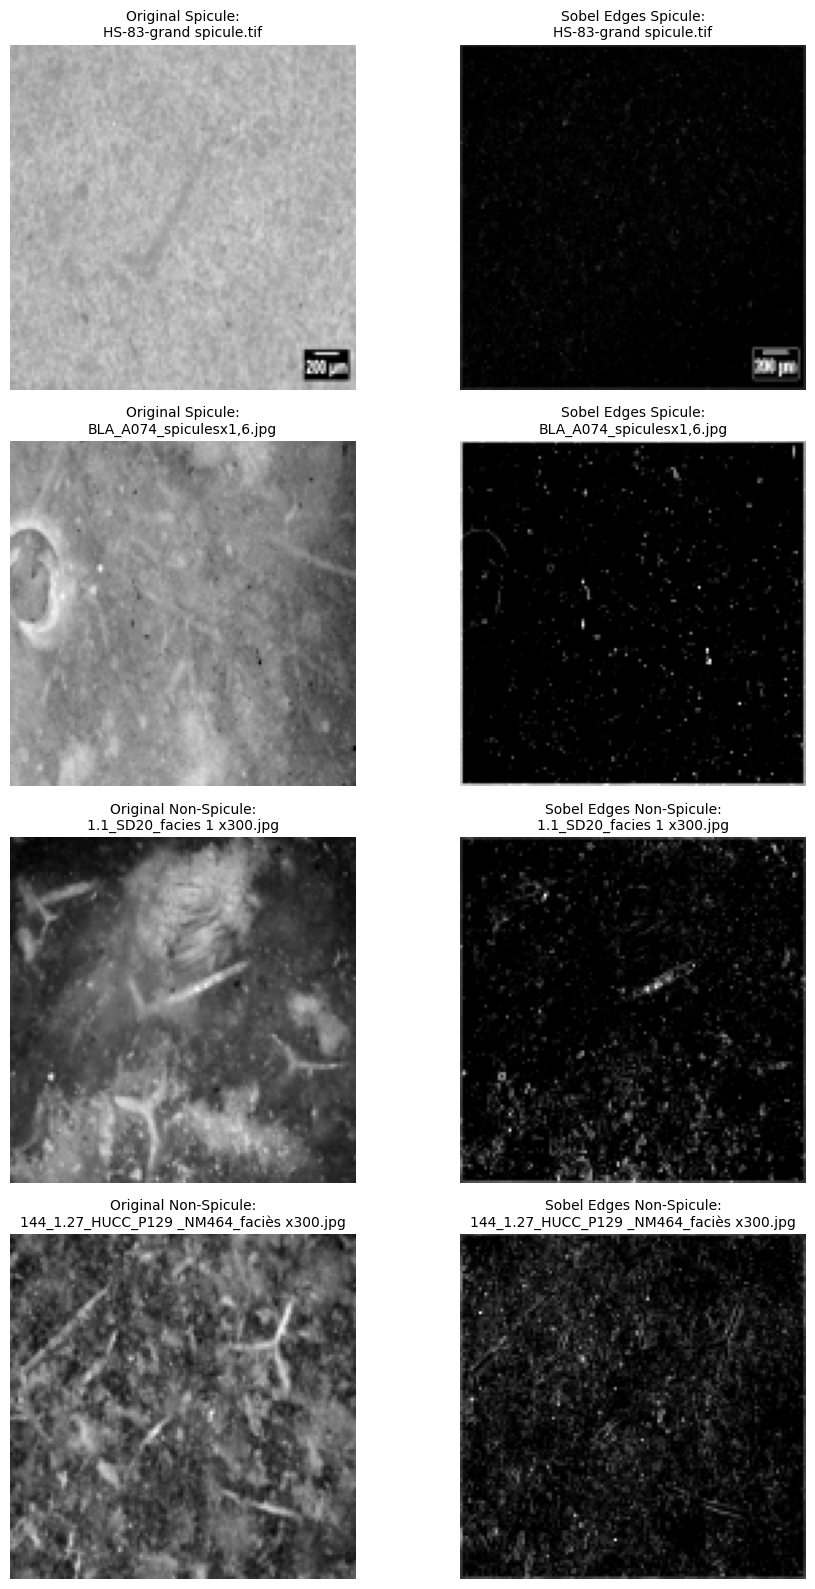

In [ ]:
spicule_files_global = [file for file in os.listdir("/content/spicule")]
non_spicule_files_global = [file for file in os.listdir("/content/pas spicule")]

def reconstruct_edge_image(weights_tensor, coords_tensor, size=(1024, 1024)):
    H, W = size
    edge_img = np.zeros(size)
    # Move tensors to CPU if they are on CUDA
    weights_cpu = weights_tensor.cpu().numpy()
    coords_cpu = coords_tensor.cpu().numpy()

    # Scale coordinates to grid indices
    # coords are normalized 0-1, so multiply by (W-1) and (H-1) to get pixel indices
    x_indices = np.round(coords_cpu[:, 0] * (W - 1)).astype(int)
    y_indices = np.round(coords_cpu[:, 1] * (H - 1)).astype(int)

    for i in range(len(weights_cpu)):
        edge_img[y_indices[i], x_indices[i]] += weights_cpu[i]

    if edge_img.max() > 0: # Avoid division by zero
        edge_img = edge_img / edge_img.max()

    return edge_img

# Select example images
if 'spicule_files_global' not in globals() or not builtins.spicule_files_global:
    print("Error: spicule_files_global not found or empty. Please run previous cells.")
    example_spicule_paths = []
else:
    # Take the first two unique spicule files that are likely to be different from references
    # Filter out files that might be used as references in the original notebook
    reference_spicule_names = [os.path.basename(f) for f in [
        "/content/spicule/APP 3919 type 601 spicule.tif",
        "/content/spicule/-F606-4459-0004-F606-spicule.tif",
        "/content/spicule/1.1_SD20_facies 1 x300.jpg"
    ]]
    example_spicule_paths = [f for f in builtins.spicule_files_global if os.path.basename(f) not in reference_spicule_names][:2]

if 'non_spicule_files_global' not in globals() or not builtins.non_spicule_files_global:
    print("Error: non_spicule_files_global not found or empty. Please run previous cells.")
    example_non_spicule_paths = []
else:
    # Take the first two unique non-spicule files that are likely to be different from references
    reference_non_spicule_names = [os.path.basename(f) for f in [
        "/content/pas spicule/sample_data/IMG_0031.JPG",
        "/content/pas spicule/sample_data/Glomospira  .tif",
        "/content/pas spicule/sample_data/Fissure 250.jpg",
    ]]
    example_non_spicule_paths = [f for f in builtins.non_spicule_files_global if os.path.basename(f) not in reference_non_spicule_names][:2]

all_example_paths = [(p, "Spicule") for p in example_spicule_paths] + \
                    [(p, "Non-Spicule") for p in example_non_spicule_paths]

if not all_example_paths:
    print("No example images selected for visualization. Please check file lists.")
else:
    fig, axes = plt.subplots(len(all_example_paths), 2, figsize=(10, 4 * len(all_example_paths)))
    if len(all_example_paths) == 1:
        axes = axes.reshape(1, -1)

    for i, (image_path, img_type) in enumerate(all_example_paths):
        # Load original image
        original_img = Image.open(image_path).convert('L')
        original_img_resized = original_img.resize((128, 128))
        original_data = np.array(original_img_resized)

        # Process with load_and_preprocess for edge detection
        weights, coords = load_and_preprocess(image_path)

        # Reconstruct edge image for visualization
        edge_img = reconstruct_edge_image(weights, coords, size=(128, 128))

        # Display original and edge-detected images
        axes[i, 0].imshow(original_data, cmap='gray')
        axes[i, 0].set_title(f"Original {img_type}:\n{os.path.basename(image_path)}", fontsize=10)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(edge_img, cmap='gray')
        axes[i, 1].set_title(f"Sobel Edges {img_type}:\n{os.path.basename(image_path)}", fontsize=10)
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()